# Behavioral Guided Single-Cell Transcriptomics Analysis (Part 5)
<span style="font-size:0.85em;">Written by: Farid Keramati (7 Mar 2024) - Last Update: Farid Keramati (10 Mar 2024)</span>

## Comparison to in vivo Breast Cancer T Cell Datasets
&#10071;<b>Note:</b> Before runnig this analysis workflow, either make sure you have already run the part 2 of the analysis pipeline, or you have downloaded corresponding Seurat object <code>(All_TEGs_MNN_Seurat.rds)</code> from Zenodo depository and have it in the current working directory.

<div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on different factors such as your operating system, R version, Seurat and other package versions the analysis results of different sections can be slightly different. However, major conclusions should not change. If you want to reproduce downstream analysis exactly same, please use the provided Seurat objects in <a><b>Zenodo</b></a> depository.
</div>

This workflow aims to identify marker genes related to highly tumor-reactive T cells in two example publicly available breast cancer tumor microenvironemet datasets and check whether those genes are also enriched in our TEG dataset's engager and super-engager clusters. For this purpose, we will first download those two datasets and identify marker genes and finaly project them on to the TEG dataset.<br/>
<details><summary><b>1. Savas (Nature Medicine) Breat Cancer T Cell Dataset</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1. Read in Data and Preprocess<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2. Normalize & Scale & Reduce dimentionality of the data<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3. Find Marker Genes of Cytotoxic T Cells<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.4. Save Seurat Object and Marker Genes (optional)</br>
</details>
<details><summary><b>2. Azizi (Cell) Breat Cancer T Cell Dataset</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1. Read in Data and Preprocess<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2. Normalize & Scale & Reduce dimentionality of the data<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3. Batch Correction<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4. Find Marker Genes of Cytotoxic T Cells<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.5. Save Seurat Object and Marker Genes (optional)</br>
</details>
<details><summary><b>3. Projection of Identified Marker Genes on TEG Dataset</b></summary></details>

### Load Required Libraries
<details><summary>For the following workflow we will need <code>Seurat</code>, <code>dplyr</code>, <code>data.table</code>, and <code>SeuratWrappers</code> libraries.
Make sure you have them installed before starting the analysis.</summary>
&nbsp;&nbsp;&nbsp;&nbsp;Use the following code to install the required packages:</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>install.packages(c("Seurat","dplyr","data.table","remotes","devtools"))</code></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>remotes::install_github('satijalab/seurat-wrappers')</code></br>
</details>

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(dplyr))
suppressMessages(library(data.table))
suppressMessages(library(SeuratWrappers))

## 1. Savas (Nature Medicine) Breat Cancer T Cell Dataset

As the first dataset we will use the dataset of breast cancer T cells published in Nature Medicine in 2018 with the title of "<b>Single-cell profiling of breast cancer T cells reveals a tissue-resident memory subset associated with improved prognosis</b>".</br>
We will name this dataset as Savas dataset, as Peter Savas is the first author of this article.

Before you run the following code, make sure you have downloaded the dataset from Gene Expression Omnibus depository with the accesssion number of <code>GSE110686</code>.</br> At the bottom of the page you should download three files with the <code>.gz</code> extension and remove the first <code>GSE110686_tils20+32_</code> from their name. </br>
We assume that you have download the dataset into a folder (inside the current working directory) with the name of <b>Savas_etal</b>.</br>
&#10071;Please change the code, if necessary, and direct to the folder where files are downloaded. 

### 1.1 Read in Data and Preprocess

In [2]:
tmp.data = Read10X(data.dir = "./Savas_etal/")
savas = suppressWarnings(CreateSeuratObject(counts=tmp.data, project="Savas", min.cells=3, min.features=50))

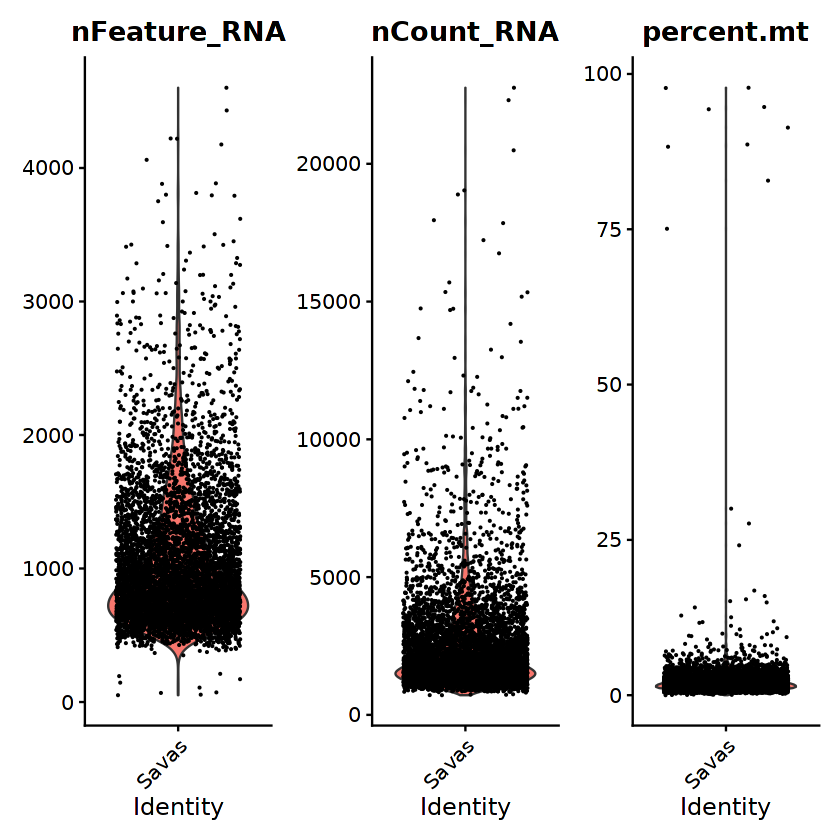

In [3]:
# Remove low quality cells
savas[["percent.mt"]] = PercentageFeatureSet(savas, pattern="MT-")
savas[["percent.rb"]] = PercentageFeatureSet(savas, pattern="^RP[LS]")
VlnPlot(savas, features=c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol=3, pt.size=0.1)
savas = subset(savas, subset=nFeature_RNA>200 & nFeature_RNA<7500 & percent.mt<4)

In [4]:
# Remove mito and rb genes
mt.genes = rownames(savas)[grep("^MT-", rownames(savas))]
rb.genes = rownames(savas)[grep("^RP[LS]", rownames(savas))]
genes = c(mt.genes, rb.genes)
genes.keep = setdiff(rownames(savas), genes)
savas = subset(savas, features=genes.keep)

In [5]:
# Remove non-coding genes
genes = read.table("genes.gtf", sep="\t")
genes = genes[genes$V3 == "gene", ]
df_genes = data.frame(gene_id = unlist(strsplit(genes$V9, ";| "))[c(F,T,F,F,F,F,F,F,F,F,F,F,F,F)],
                      gene_name = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,T,F,F,F,F,F,F)],
                      gene_biotype = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,F,F,F,F,F,F,T)])
df_genes = df_genes[df_genes$gene_biotype=="protein_coding",]
savas = subset(savas, features = df_genes$gene_name)

### 1.2 Normalize & Scale & Reduce dimentionality of the data
For this step we utilized the <code><a>Guided Clustering Tutorial</a></code>workflow, suggested by the authors of <code>Seurat</code> package.

In [6]:
# Normalized & Scale & PCA dimentionality reduction
savas = NormalizeData(savas, verbose=F) %>% FindVariableFeatures(nfeatures=5000) %>% 
     ScaleData(verbose=F) %>% RunPCA(verbose=F)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 874
Number of edges: 54872

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6581
Number of communities: 2
Elapsed time: 0 seconds


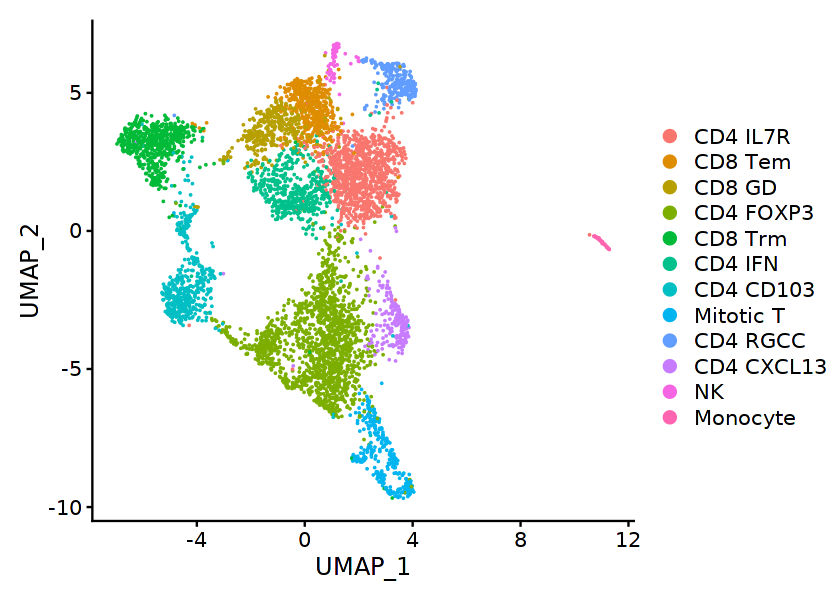

In [7]:
# UMAP embedding & Clusting
savas = suppressWarnings(RunUMAP(savas, dims=1:30, verbose=F)) %>% FindNeighbors(dims=1:30, k.param=30, verbose=F) %>%
     FindClusters(resolution=1, verbose=F)

# Further subset cluster 1 (to have separated gd T cells)
savas = FindSubCluster(savas, cluster=1, graph.name="RNA_snn")
Idents(savas) = savas$sub.cluster

# Name the clusters
savas = RenameIdents(savas, "0"="CD4 IL7R", "1_0"="CD8 Tem", "1_1"="CD8 GD", "2"="CD4 FOXP3", "3"="CD8 Trm", "4"="CD4 FOXP3",
                  "5"="CD4 IFN", "6"="CD4 CD103", "7"="Mitotic T", "8"="CD4 FOXP3", "9"="CD4 RGCC", "10"="CD4 CXCL13",
                  "11"="NK", "12"="Monocyte")

# Plot Cells
options(repr.plot.width=7, repr.plot.height=5)
DimPlot(savas, pt.size=0.01)

### 1.3 Find Marker Genes of Cytotoxic T Cells
Savas et al, in their manuscript have defined CD8 Trm cluster of cells as the most cytotoxic cells with high prognostic value in the favor of fight against breast cancer. </br>
We will identify the marker genes related to that cluster using <code>FindMarkers</code> from <code>Seurat</code> package and visualize them on the UMAP.

In [9]:
genes_savas = FindMarkers(savas, only.pos=T, min.pct=0.3, min.diff.pct=0.1, logfc.threshold=0.3, ident.1="CD8 Trm")

# Calculate the enrichment for identified marker genes
savas = AddModuleScore(savas, features=list(rownames(genes_savas)), name="Cytotoxic_Savas")

# Visualize
FeaturePlot(savas, order=T, max.cutoff="q99", min.cutoff="q20", "Cytotoxic_Savas1")

### 1.4 Save Seurat Object and Marker Genes (optional)
You can save the resulting Seurat object and identified marker genes for future use, if you wish to.

In [8]:
saveRDS(savas, "Savas_Tcell.rds")
saveRDS(genes_savas, "Savas_CD8_Trm_MarkerGenes.rds")

## 2. Azizi (Cell) Breat Cancer T Cell Dataset

As the second dataset we will use the dataset of breast cancer tumor microenvironement T cells published in Cell in 2018 with the title of "<b>Single-Cell Map of Diverse Immune Phenotypes in the Breast Tumor Microenvironment</b>".</br>
We will name this dataset as Azizi dataset, as Elham Azizi is the first author of this article.

Before you run the following code, make sure you have downloaded the dataset from Gene Expression Omnibus depository with the accesssion number of <code>GSE114724</code>.</br> At the bottom of the page you should download file with the title of <code>GSE114724_rna_raw.tsv.gz</code> and unzip it using an appropriate tool or command such as <code>gunzip</code>. </br>
We assume that you have download the dataset into a folder (inside the current working directory) with the name of <b>Azizi_etal</b>.</br>
&#10071;Please change the code, if necessary, and direct to the folder where files are downloaded. 

### 2.1 Read in Data and Preprocess

In [12]:
tmp.data = fread("./Azizi_etal/GSE114724_rna_raw.tsv", sep="\t")

In [13]:
genes = tmp.data$Patient
genes = genes[2:length(genes)]
tmp.data$Patient = NULL
cell_name = tmp.data[1,]
colnames(tmp.data) = paste(colnames(tmp.data), cell_name, sep="_")
tmp.data = tmp.data[-1,]
tmp.data = data.frame(tmp.data)
rownames(tmp.data) = genes

In [14]:
azizi = suppressWarnings(CreateSeuratObject(counts=tmp.data, project="Azizi", min.cells=3, min.features=50))
rm(tmp.data)

In [15]:
# Remove mito and rb genes
mt.genes = rownames(azizi)[grep("^MT-", rownames(azizi))]
rb.genes = rownames(azizi)[grep("^RP[LS]", rownames(azizi))]
genes = c(mt.genes, rb.genes)
genes.keep = setdiff(rownames(azizi), genes)
azizi = subset(azizi, features=genes.keep)

In [16]:
# Remove non-coding genes
genes = read.table("genes.gtf", sep = "\t")
genes = genes[genes$V3 == "gene", ]
df_genes = data.frame(gene_id = unlist(strsplit(genes$V9, ";| "))[c(F,T,F,F,F,F,F,F,F,F,F,F,F,F)],
                      gene_name = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,T,F,F,F,F,F,F)],
                      gene_biotype = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,F,F,F,F,F,F,T)])
df_genes = df_genes[df_genes$gene_biotype=="protein_coding",]
azizi = subset(azizi, features = df_genes$gene_name)

### 2.2 Normalize & Scale & Reduce dimentionality of the data
For this step we utilized the <code><a>Guided Clustering Tutorial</a></code>workflow, suggested by the authors of <code>Seurat</code> package.

In [17]:
# Normalized & Scale & PCA dimentionality reduction
azizi = NormalizeData(azizi, verbose=F) %>% FindVariableFeatures(nfeatures = 5000) %>% 
     ScaleData(verbose=F) %>% RunPCA(verbose=F)

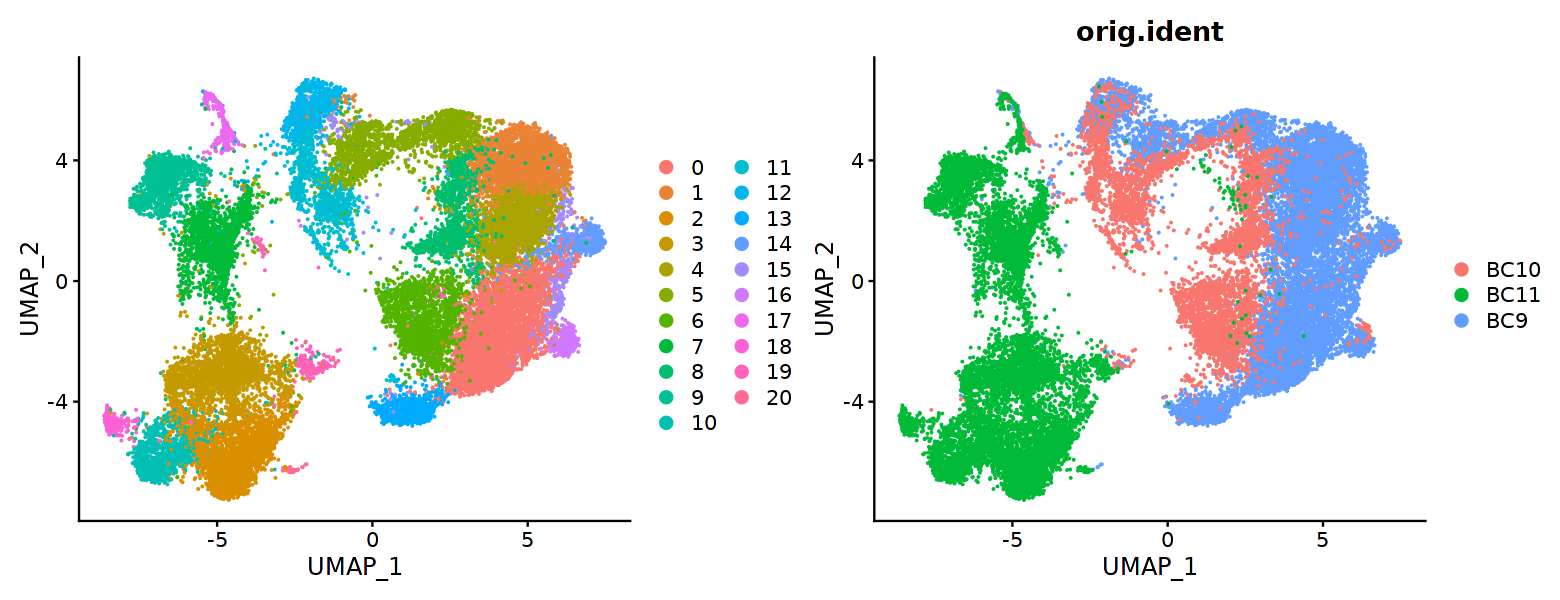

In [18]:
# UMAP embedding & Clusting
azizi = RunUMAP(azizi, dims=1:30, verbose=F) %>% FindNeighbors(dims=1:30, k.param=30, verbose=F) %>%
     FindClusters(resolution=1, verbose=F)

# Plot Cells
options(repr.plot.width=13, repr.plot.height=5)
DimPlot(azizi) + DimPlot(azizi, group.by="orig.ident")

### 2.3 Batch Correction
Based on the results of the previous section, there is a clear donor batch effect that needs to be corrected.</br>
We will use <code>RunFastMNN</code> function from <code>SeuratWrappers</code> package, which is a fast implementation of the original <code>MNN</code> algorithm.

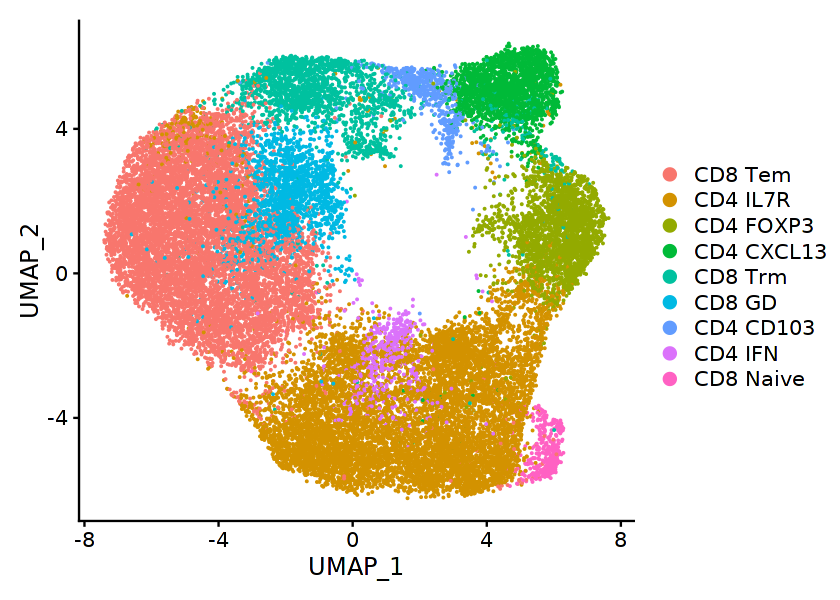

In [19]:
# Batch correct for donor differences with MNN
azizi_mnn = RunFastMNN(object.list=SplitObject(azizi, split.by="orig.ident"), features=1000, verbose=F)
azizi_mnn = RunUMAP(azizi_mnn, dims=1:10, reduction="mnn", min.dist=0.3, verbose=F) %>% 
     FindNeighbors(dims=1:30, k.param=30, reduction="mnn", verbose=F) %>% FindClusters(resolution=1, verbose=F)

# Name the clusters
azizi_mnn = RenameIdents(azizi_mnn, "0"="CD8 Tem", "1"="CD4 IL7R", "2"="CD4 FOXP3", "3"="CD4 IL7R", "4"="CD8 Tem",
                  "5"="CD4 CXCL13", "6"="CD8 Tem", "7"="CD4 IL7R", "8"="CD8 Trm", "9"="CD8 GD", "10"="CD4 IL7R",
                  "11"="CD4 IL7R", "12"="CD8 GD", "13"="CD8 Trm", "14"="CD4 CD103", "15"="CD4 IL7R",
                  "16"="CD4 IFN", "17"="CD8 Naive", "18"="CD8 Tem", "19"="CD8 Trm")

# Plot Cells
options(repr.plot.width=7, repr.plot.height=5)
DimPlot(azizi_mnn)

### 2.4 Find Marker Genes of Cytotoxic T Cells
We will, again, identify marker genes of CD8 Trm cluster of cells as the most cytotoxic cells in the fight against breast cancer. </br>
We will identify the marker genes related to that cluster using <code>FindMarkers</code> from <code>Seurat</code> package and visualize them on the UMAP.

In [21]:
genes_azizi = FindMarkers(azizi_mnn, only.pos=T, min.pct=0.3, min.diff.pct=0.1, logfc.threshold=0.3, ident.1="CD8 Trm")

# Calculate the enrichment for identified marker genes
azizi_mnn = AddModuleScore(azizi_mnn, features=list(rownames(genes_azizi)), name="Cytotoxic_Azizi")

# Visualize
options(repr.plot.width=6, repr.plot.height=5)
FeaturePlot(azizi_mnn, order=T, max.cutoff="q99", min.cutoff="q20", "Cytotoxic_Azizi1")

### 2.5 Save Seurat Object and Marker Genes (optional)
You can save the resulting Seurat object and identified marker genes for future use, if you wish to.

In [20]:
saveRDS(azizi_mnn, "Azizi_Tcell.rds")
saveRDS(genes_azizi, "Azizi_CD8_Trm_MarkerGenes.rds")

## 3. Projection of Identified Marker Genes on TEG Dataset

After identifying the marker genes of highly effective T cells in the fight against from two example in vivo-derived datasets, we calculate and project the enrichment of those genes (separately and together) on our own TEG dataset.

&#10071;<b>Note:</b> For this step, you need to have access to <code>All_TEG_Seurat.rds</code> Seurat object, which is the final result of part 2 of this analysis pipeline.

In [24]:
teg = readRDS("All_TEGs_MNN_Seurat.rds")

In [28]:
teg = suppressWarnings(AddModuleScore(teg, features=list(rownames(genes_savas)), name="Cytotoxic_Savas"))
teg = suppressWarnings(AddModuleScore(teg, features=list(rownames(genes_azizi)), name="Cytotoxic_Azizi"))

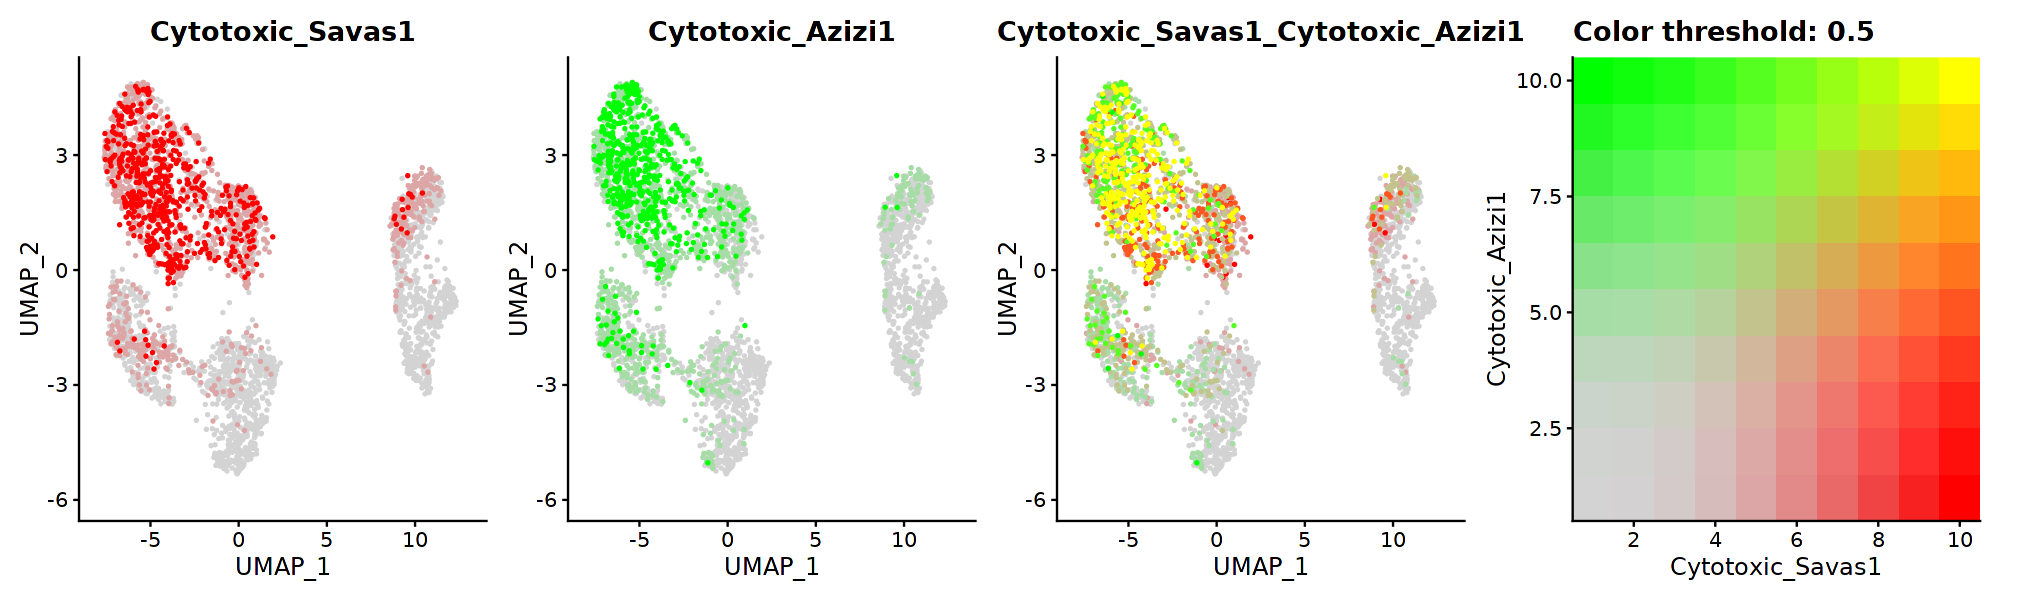

In [29]:
options(repr.plot.width=17, repr.plot.height=5)
FeaturePlot(teg, order=T, max.cutoff="q99", min.cutoff="q20", features = c("Cytotoxic_Savas1","Cytotoxic_Azizi1"), blend = T)

In [27]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] SeuratWrappers_0.3.0 data.table_1.14.0    dplyr_1.0.5         
[4] SeuratObject_4.0.0   Seurat_3.9.9.9038   

loaded via a namespace (and not attached):
  [1] uuid_0.1-4                  plyr_1.8.6                 
  [3] igraph_1.2.6                rep